In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

CV_verbose_param = 3

In [25]:
dataset = pd.read_csv('datasets/spotify_tracks_cleaned.csv')
dataset.head()

,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,...,GENRE_spanish,GENRE_study,GENRE_swedish,GENRE_synth-pop,GENRE_tango,GENRE_techno,GENRE_trance,GENRE_trip-hop,GENRE_turkish,GENRE_world-music
0,Rill,Lolly,Lolly,160725,True,0.910,0.374,8,-9.844,0,...,0,0,0,0,0,0,0,0,0,0
1,Glee Cast,Glee Love Songs,It's All Coming Back To Me Now (Glee Cast Vers...,322933,False,0.269,0.516,0,-7.361,1,...,0,0,0,0,0,0,0,0,0,0
2,Paul Kalkbrenner;Pig&Dan,X,Böxig Leise - Pig & Dan Remix,515360,False,0.686,0.560,5,-13.264,0,...,0,0,0,0,0,0,0,0,0,0
3,Jordan Sandhu,Teeje Week,Teeje Week,190203,False,0.679,0.770,0,-3.537,1,...,0,0,0,0,0,0,0,0,0,0
4,Paul Kalkbrenner,Zeit,Tief,331240,False,0.519,0.431,6,-13.606,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# dropping columns corresponding to categorical features

numerical_features = ['duration_ms','danceability','energy','loudness','speechiness',
          'acousticness','instrumentalness','liveness','valence','tempo','popularity']
columns_to_drop = list(dataset.columns)
for c in numerical_features:
    columns_to_drop.remove(c)
dataset.drop(columns=columns_to_drop, inplace=True)

In [27]:
X = dataset.drop(columns=['popularity'])    # features
y = dataset['popularity']                   # target variable

In [30]:
X['popularity_subsamples'] = y.map(lambda x: x if x % 2 == 0 else x+1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['popularity_subsamples'])

X_train.drop(columns='popularity_subsamples', inplace=True)
X_test.drop(columns='popularity_subsamples', inplace=True)

### Features selection

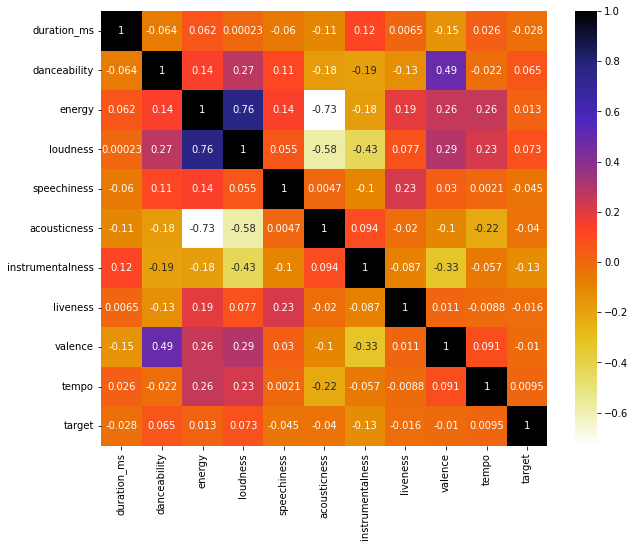

In [31]:
all_data = X_train.copy()
all_data['target'] = y_train
plt.figure(figsize=(10,8))
sns.heatmap(all_data.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

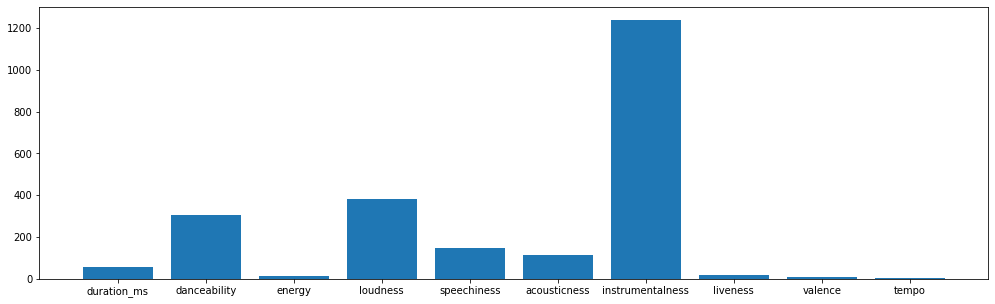

In [32]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X_train, y_train)

plt.figure(figsize=(17,5))
plt.bar([X_train.columns[i] for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [33]:
worst_features = ['energy', 'liveness', 'valence', 'tempo']
X_train.drop(columns=worst_features, inplace=True)
X_test.drop(columns=worst_features, inplace=True)

### Features normalization

In [34]:
standard_scaler = preprocessing.StandardScaler().set_output(transform="pandas")

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

## *Ridge Regression* on *Spotify Tracks Dataset* 

In [35]:
from ridge_regression import RR

### Hyperparameters tuning

In [36]:
λ_grid = np.linspace(0, 120, num=20)

learner = GridSearchCV(estimator=RR(), n_jobs=-1, param_grid={'λ': λ_grid}, scoring='neg_mean_squared_error', cv=5, verbose=CV_verbose_param)
learner.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 2/5] END ..........................λ=0.0;, score=-415.502 total time=   0.0s
[CV 4/5] END ............λ=6.315789473684211;, score=-411.082 total time=   0.0s
[CV 5/5] END ............λ=6.315789473684211;, score=-412.072 total time=   0.0s
[CV 1/5] END ...........λ=12.631578947368421;, score=-414.225 total time=   0.0s
[CV 2/5] END ...........λ=12.631578947368421;, score=-415.502 total time=   0.0s
[CV 3/5] END ...........λ=12.631578947368421;, score=-412.238 total time=   0.0s
[CV 4/5] END ...........λ=12.631578947368421;, score=-411.082 total time=   0.0s
[CV 1/5] END ..........................λ=0.0;, score=-414.225 total time=   0.0s
[CV 3/5] END ..........................λ=0.0;, score=-412.238 total time=   0.0s
[CV 5/5] END ...........λ=12.631578947368421;, score=-412.072 total time=   0.0s
[CV 1/5] END ............λ=18.94736842105263;, score=-414.225 total time=   0.0s
[CV 2/5] END ............λ=18.94736842105263;, 

GridSearchCV(cv=5, estimator=RR(), n_jobs=-1,
             param_grid={'λ': array([  0.        ,   6.31578947,  12.63157895,  18.94736842,
        25.26315789,  31.57894737,  37.89473684,  44.21052632,
        50.52631579,  56.84210526,  63.15789474,  69.47368421,
        75.78947368,  82.10526316,  88.42105263,  94.73684211,
       101.05263158, 107.36842105, 113.68421053, 120.        ])},
             scoring='neg_mean_squared_error', verbose=3)

In [37]:
print(f'Best hyperparams is λ = {learner.best_params_["λ"]} with a score of {learner.best_score_}')

Best hyperparams is λ = 63.15789473684211 with a score of -413.0235581507989


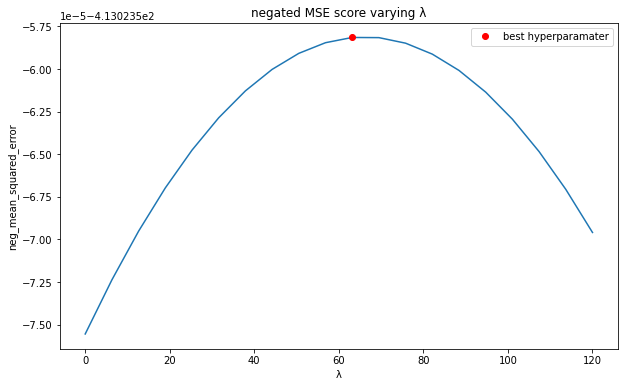

In [38]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)
ax.plot(learner.cv_results_['param_λ'].data, learner.cv_results_['mean_test_score'])
ax.plot(learner.best_params_['λ'], learner.best_score_, 'ro', label="best hyperparamater") 
ax.set(xlabel='λ', ylabel='neg_mean_squared_error', title='negated MSE score varying λ')
plt.legend()
plt.show()

In [39]:
def print_performance(y_test, y_prediction):
    print('MSE :', mean_squared_error(y_test, y_prediction))
    print('MAE :', mean_absolute_error(y_test, y_prediction))
    print(' R2 :', r2_score(y_test, y_prediction))

In [40]:
rr = learner.best_estimator_
rr.fit(X_train, y_train)
y_prediction = rr.predict(X_test)

print_performance(y_test, y_prediction)

MSE : 414.14901640285245
MAE : 16.851320134208876
 R2 : 0.0200125876389442


In [41]:
def residuals_analysis(y_test, y_prediction):
    
    residuals = y_test - y_prediction

    q1 = np.quantile(residuals, 0.25)
    q2 = np.quantile(residuals, 0.5)
    q3 = np.quantile(residuals, 0.75)
    iqr = q3 - q1

    print(f'q1          : {q1}')
    print(f'q2 (median) : {q2}')
    print(f'q3          : {q3}')
    print(f'IQR         : {iqr}')

    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(5)
    n, _, _  = ax.hist(residuals, density=True, bins=100)
    plt.errorbar(q2, max(n) + 0.002, xerr = [[q2-q1],[q3-q2]], fmt ='o', label="IQR") 
    plt.xlabel("residual (test - prediction)")
    plt.ylabel("relative frequency")
    plt.title("Density plot of the residuals")
    plt.legend()
    plt.show()

q1          : -13.62691760739159
q2 (median) : -0.2069325396722803
q3          : 15.220022156963303
IQR         : 28.846939764354893


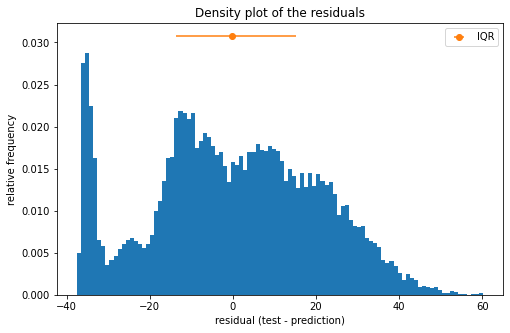

In [42]:
residuals_analysis(y_test, y_prediction)

Checking that my implementation performs exactly as the one in *sklearn*

In [43]:
from sklearn.linear_model import Ridge

debug = True

if debug:

    rr = Ridge(alpha=learner.best_params_['λ'])
    rr.fit(X_train, y_train)
    y_prediction = rr.predict(X_test)

    print_performance(y_test, y_prediction)

MSE : 414.14901640285245
MAE : 16.851320134208873
 R2 : 0.0200125876389442


## *Kernel Ridge Regression* on *Spotify Tracks Dataset*

Warning : some of the cells below will take 2-3 minutes to run

In [44]:
from kernel_ridge_regression import KRR

We run KRR just on samples of the dataset because, otherwise, it would get too computationally expensive 

In [45]:
train_sample_size = 5000
test_sample_size = 1000

X_train_sample = X_train.sample(n=train_sample_size, random_state=1)
y_train_sample = pd.Series(data = [y_train[i] for i in X_train_sample.index], index = X_train_sample.index)

X_test_sample = X_test.sample(n=test_sample_size, random_state=1)
y_test_sample = pd.Series(data = [y_test[i] for i in X_test_sample.index], index = X_test_sample.index)

### Hyperparameters tuning

In [46]:
λ_grid = 10. ** np.arange(-2, 3) 
γ_grid = 10. ** np.arange(-1, 4) 

learner = GridSearchCV(estimator=KRR(), n_jobs=-1, param_grid={'λ': λ_grid, 'γ': γ_grid}, scoring='neg_mean_squared_error', cv=5, verbose=CV_verbose_param)
learner.fit(X_train_sample, y_train_sample)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: 

In [ ]:
print(f'Best hyperparams are λ = {learner.best_params_["λ"]} and γ = {learner.best_params_["γ"]} with a score of {learner.best_score_}')

Best hyperparams are λ = 1.0 and γ = 10.0 with a score of -394.1811561430313


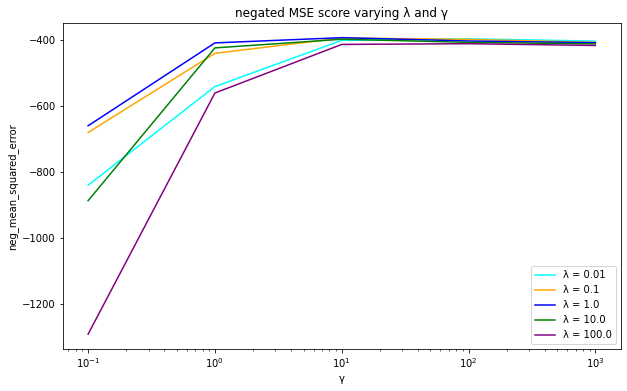

In [ ]:
score = learner.cv_results_['mean_test_score']

dict_λ = {}
for v in set(learner.cv_results_['param_λ'].data):
    dict_λ[v] = (sorted(set(learner.cv_results_['param_γ'].data)), [])
for i, p in enumerate(learner.cv_results_['params']):
    dict_λ[p['λ']][1].append(score[i])

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

colors = ['purple', 'green', 'blue', 'orange', 'cyan']
for k in sorted(dict_λ.keys()):
    ax.plot(dict_λ[k][0], dict_λ[k][1], label = f"λ = {k}", linestyle="-", color = colors.pop())

ax.set(xscale='log', xlabel='γ', ylabel='neg_mean_squared_error', title='negated MSE score varying λ and γ')
plt.legend()
plt.show()

In [ ]:
train_sample_size_BIG = 20000
test_sample_size_BIG = 4000

X_train_sample_BIG = X_train.sample(n=train_sample_size_BIG, random_state=1)
y_train_sample_BIG = pd.Series(data = [y_train[i] for i in X_train_sample_BIG.index], index = X_train_sample_BIG.index)

X_test_sample_BIG = X_test.sample(n=test_sample_size_BIG, random_state=1)
y_test_sample_BIG = pd.Series(data = [y_test[i] for i in X_test_sample_BIG.index], index = X_test_sample_BIG.index)

In [ ]:
krr = learner.best_estimator_
krr.fit(X_train_sample_BIG, y_train_sample_BIG)
y_prediction = krr.predict(X_test_sample_BIG)

print_performance(y_test_sample_BIG, y_prediction)

MSE : 377.8658357061992
MAE : 15.863612520634558
 R2 : 0.06353998914848746


q1          : -12.791812528756026
q2 (median) : 0.11151876161935625
q3          : 14.253771938928015
IQR         : 27.04558446768404


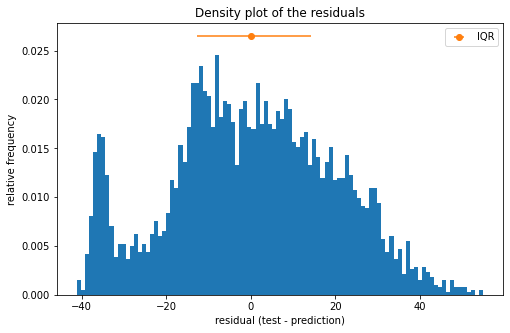

In [ ]:
residuals_analysis(y_test_sample_BIG, y_prediction)

Checking that my implementation performs exactly as the one in *sklearn*

In [ ]:
from sklearn.kernel_ridge import KernelRidge

debug = True

if debug:

    krr = KernelRidge(alpha=learner.best_params_["λ"], kernel="rbf", gamma=1/(learner.best_params_["γ"] * 2))
    krr.fit(X_train_sample_BIG, y_train_sample_BIG)
    y_prediction = krr.predict(X_test_sample_BIG)

    print_performance(y_test_sample_BIG, y_prediction)

MSE : 377.86583570619894
MAE : 15.86361252063455
 R2 : 0.06353998914848813
